In [0]:
%pip install tensorflow==2.12.0
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 75.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [0]:
%pip install opencv-python joblib pandas numpy matplotlib seaborn tqdm scikit-learn keras
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 16.0 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
import os
import cv2
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.notebook import tqdm

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, RocCurveDisplay, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer,LabelEncoder, label_binarize
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import LinearSVC

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, save_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.applications import DenseNet121
from sklearn.metrics import roc_curve, auc

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from keras.backend import clear_session
import gc

2025-05-22 14:02:19.324108: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Data loading

In [0]:
test_path ='/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test/'

#"/content/drive/MyDrive/RAF-DB/test"
train_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'

#"/content/drive/MyDrive/RAF-DB/train"
test_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test_labels (1).csv'
#"/content/drive/MyDrive/RAF-DB/test_labels.csv"
train_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train_labels (1).csv'
 #"/content/drive/MyDrive/RAF-DB/train_labels.csv"


In [0]:
train_labels = pd.read_csv(train_label_path)
test_labels = pd.read_csv(test_label_path)

In [0]:
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
emotion_to_label = {emotion: label_id for label_id, emotion in enumerate(emotion_classes, start=1)}
emotion_to_label

{'surprise': 1,
 'fear': 2,
 'disgust': 3,
 'happy': 4,
 'sad': 5,
 'angry': 6,
 'neutral': 7}

In [0]:
def load_data(dataset_dir, label_map):
    images = []
    labels = []

    for label, idx in tqdm(label_map.items()):
        folder_path = os.path.join(dataset_dir, str(idx))
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(idx)

    return np.array(images), np.array(labels)

train_images, train_labels = load_data(train_path, emotion_to_label)
test_images, test_labels = load_data(test_path, emotion_to_label)
print(train_images.shape)
print(test_images.shape)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

(12271, 100, 100, 3)
(3068, 100, 100, 3)


#Inspect data proportionality

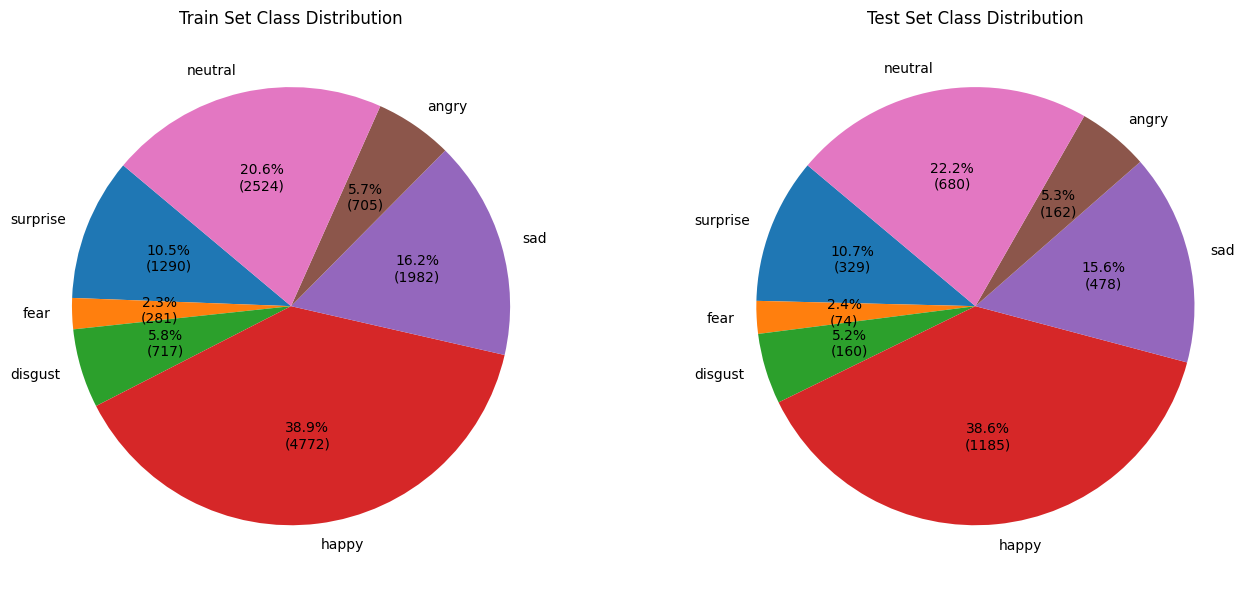

In [0]:
unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']

def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return autopct

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].pie(counts_train, labels=emotion_classes, autopct=make_autopct(counts_train), startangle=140)
axes[0].set_title('Train Set Class Distribution')

axes[1].pie(counts_test, labels=emotion_classes, autopct=make_autopct(counts_test), startangle=140)
axes[1].set_title('Test Set Class Distribution')

plt.tight_layout()
plt.show()


In [0]:
X_train = np.concatenate([train_images, test_images], axis=0)
Y_train = np.concatenate([train_labels, test_labels], axis=0)
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

print(X_train.shape)
print(Y_train.shape)

(15339, 100, 100, 3)
(15339,)


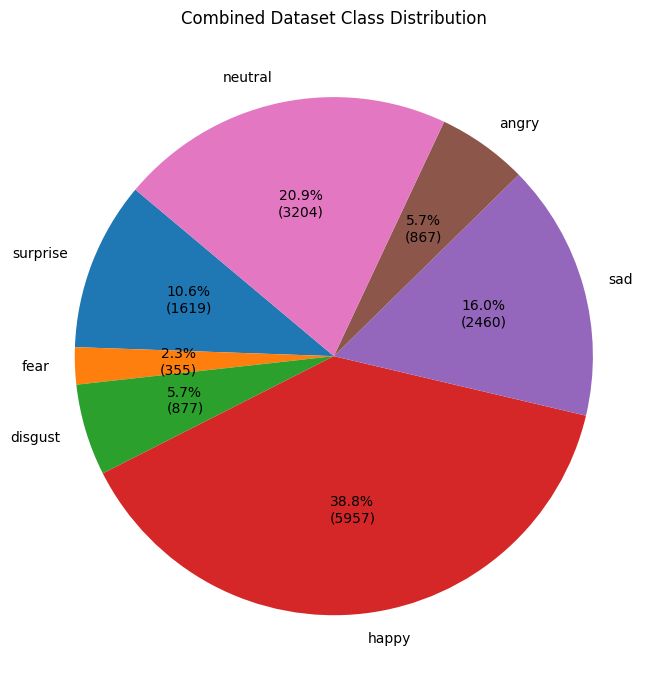

In [0]:
#Combined datasets
unique_combined, counts_combined = np.unique(Y_train, return_counts=True)
emotion_classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
def make_autopct(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{pct:.1f}%\n({count})"
    return autopct

plt.figure(figsize=(7, 7))
plt.pie(counts_combined, labels=emotion_classes, autopct=make_autopct(counts_combined), startangle=140)
plt.title('Combined Dataset Class Distribution')
plt.tight_layout()
plt.show()

#Balancing the dataset

In [0]:
def reduce_class(X, y, target_class, target_size):

    class_indices = np.where(y == target_class)[0]
    non_class_indices = np.where(y != target_class)[0]
    reduced_class_indices = np.random.choice(class_indices, target_size, replace=False)
    final_indices = np.concatenate([reduced_class_indices, non_class_indices])
    X_reduced = X[final_indices]
    y_reduced = y[final_indices]

    return X_reduced, y_reduced

target_class = 4
target_size = 3500
X_train_reduced, y_train_reduced = reduce_class(X_train, Y_train, target_class, target_size)

print(y_train_reduced.shape)
print(X_train_reduced.shape)

(12882,)
(12882, 100, 100, 3)


In [0]:
X_train_reduced[1]

array([[[ 49,  32,  24],
        [ 49,  31,  21],
        [ 54,  32,  21],
        ...,
        [132,  83,  66],
        [118,  71,  53],
        [109,  62,  44]],

       [[ 49,  30,  23],
        [ 50,  30,  21],
        [ 57,  33,  21],
        ...,
        [136,  87,  70],
        [124,  75,  58],
        [115,  68,  50]],

       [[ 47,  27,  18],
        [ 52,  30,  19],
        [ 62,  36,  23],
        ...,
        [143,  92,  73],
        [132,  81,  62],
        [123,  75,  55]],

       ...,

       [[ 35,  25,  24],
        [ 34,  24,  23],
        [ 32,  22,  20],
        ...,
        [ 33,  29,  26],
        [ 32,  28,  25],
        [ 29,  25,  22]],

       [[ 40,  30,  29],
        [ 40,  30,  29],
        [ 38,  28,  26],
        ...,
        [ 33,  29,  26],
        [ 28,  24,  21],
        [ 24,  20,  17]],

       [[ 45,  35,  34],
        [ 46,  36,  35],
        [ 43,  33,  31],
        ...,
        [ 32,  28,  25],
        [ 25,  21,  18],
        [ 20,  16,  13]]

In [0]:
def create_datagen():
  gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        vertical_flip=False,
        horizontal_flip=True,
        channel_shift_range=20.0,
        fill_mode='nearest',
        brightness_range=(0.8, 1.2))
  return gen

def augment_single_class(class_images, class_label, augment_count, datagen):
    augmented_imgs = []
    augmented_labels = []

    for batch in datagen.flow(class_images, batch_size=1, seed=42):
        aug_image = batch[0].astype(np.uint8)
        augmented_imgs.append(aug_image)
        augmented_labels.append(class_label)

        if len(augmented_imgs) >= augment_count:
            break

    return np.array(augmented_imgs), np.array(augmented_labels)


def augment_classes(images, labels, target_counts):

    datagen = create_datagen()
    augmented_images = images.copy()
    augmented_labels = labels.copy()

    for class_label, desired_count in target_counts.items():
        class_images = images[labels == class_label]
        current_count = len(class_images)
        augment_count = desired_count - current_count

        if augment_count > 0:
            print(f"Class {class_label}: {current_count} → augmenting with {augment_count} samples")

            new_imgs, new_labels = augment_single_class(class_images, class_label, augment_count, datagen)

            augmented_images = np.vstack((augmented_images, new_imgs))
            augmented_labels = np.hstack((augmented_labels, new_labels))

    return augmented_images, augmented_labels

In [0]:
target_counts = {1: 3500, 2: 3500, 3: 3500, 5: 3500, 6: 3500, 7: 3500}
X_train_augmented, y_train_augmented = augment_classes(X_train_reduced, y_train_reduced, target_counts)

Class 1: 1619 → augmenting with 1881 samples
Class 2: 355 → augmenting with 3145 samples
Class 3: 877 → augmenting with 2623 samples
Class 5: 2460 → augmenting with 1040 samples
Class 6: 867 → augmenting with 2633 samples
Class 7: 3204 → augmenting with 296 samples


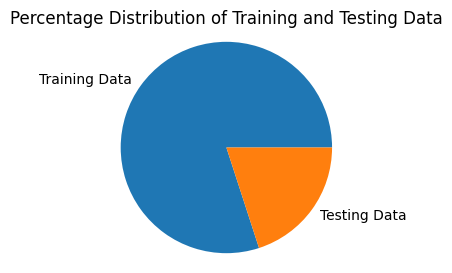

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_augmented,
                                                    y_train_augmented,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

total_images = len(X_train) + len(X_test)
train_percentage = (len(X_train) / total_images) * 100
test_percentage = (len(X_test) / total_images) * 100
plt.figure(figsize=(3, 3))
plt.pie([train_percentage, test_percentage], labels=['Training Data', 'Testing Data'])
plt.title('Percentage Distribution of Training and Testing Data')
plt.axis('equal')
plt.show()

# Normalization

In [0]:
def normalize_images(images):
    # Normalize pixel values to [0, 1]
    return images / 255.0

train_images_normalized = normalize_images(X_train)
test_images_normalized = normalize_images(X_test)

# Reshaping for CNN

In [0]:
train_images_CNNreshaped = train_images_normalized.reshape((train_images_normalized.shape[0], 100, 100, 3))
test_images_CNNreshaped = test_images_normalized.reshape((test_images_normalized.shape[0], 100, 100, 3))

In [0]:
classes = ['surprise', 'fear', 'disgust', 'happy', 'sad', 'angry', 'neutral']
Y_train_cat = to_categorical(Y_train - 1, num_classes=len(classes))
Y_test_cat = to_categorical(Y_test - 1, num_classes=len(classes)) 

#CNN model

In [0]:
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    MaxPooling2D, Add, GlobalAveragePooling2D,
    Dense, Dropout, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import layers

class SEBlock(layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        se = self.squeeze(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = tf.reshape(se, [-1, 1, 1, tf.shape(inputs)[-1]])
        return inputs * se

img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

inputs = layers.Input(shape=img_shape)

# First block with residual connection
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
# Add residual connection
shortcut1 = layers.Conv2D(filters=64, kernel_size=(1, 1), padding='same')(inputs)
x = layers.Add()([x, shortcut1])
x = layers.MaxPooling2D((2, 2))(x)

# Second block with residual connection
shortcut2 = x
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
# Add residual connection
shortcut2 = layers.Conv2D(filters=128, kernel_size=(1, 1), padding='same')(shortcut2)
x = layers.Add()([x, shortcut2])
x = layers.MaxPooling2D((2, 2))(x)

# Third block with residual connection
shortcut3 = x
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
# Add residual connection
shortcut3 = layers.Conv2D(filters=256, kernel_size=(1, 1), padding='same')(shortcut3)
x = layers.Add()([x, shortcut3])
x = layers.MaxPooling2D((2, 2))(x)

# Fourth block with residual connection
shortcut4 = x
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
# Add residual connection
shortcut4 = layers.Conv2D(filters=512, kernel_size=(1, 1), padding='same')(shortcut4)
x = layers.Add()([x, shortcut4])
x = layers.MaxPooling2D((2, 2))(x)

x = SEBlock(512)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(7, activation="softmax")(x)  

model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_119 (Conv2D)            (None, 100, 100, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_120 (Conv2D)            (None, 100, 100, 64  36928       ['conv2d_119[0][0]']             
                                )                                                          

In [0]:
datagen = ImageDataGenerator(
    rotation_range=20,             
    width_shift_range=0.1,         
    height_shift_range=0.1,  
    vertical_flip=False,               
    horizontal_flip=True, 
    fill_mode='nearest'
)

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(test_images_CNNreshaped[0].shape)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 10, 10, 128)      0

#Training

In [0]:
datagen =  ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                vertical_flip=False,
                horizontal_flip=True,
                channel_shift_range=20.0,
                fill_mode='nearest',
                brightness_range=(0.8, 1.2))

# Create the generator for training
train_generator = datagen.flow(train_images_CNNreshaped, Y_train_cat, batch_size=64)

In [0]:
%pip install dagshub

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 9.7 MB/s eta 0:00:00
     ━━━

In [0]:
import tensorflow as tf
import dagshub
from dagshub import init
import mlflow
import mlflow.tensorflow

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

x_val, x_test, y_val, y_test = train_test_split(
    test_images_CNNreshaped, Y_test_cat,
    test_size=0.5,
    random_state=42,
    shuffle=True
)
# (this will set MLFLOW_TRACKING_URI, USERNAME and PASSWORD for you)
init(repo_name="Emotion_Recognition", repo_owner="dimna21", mlflow=True)

# (optional) pick an experiment name
mlflow.set_experiment("Emotion_Recognition_4")

# enable automatic logging of all your args, metrics, metrics and models
mlflow.tensorflow.autolog()
CNN_logs = model.fit(
    train_images_CNNreshaped,
    Y_train_cat,
    epochs=10,
    batch_size=256,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, checkpoint]
)

Initialized MLflow to track repo "dimna21/Emotion_Recognition"

Repository dimna21/Emotion_Recognition initialized!

2025/05/22 14:25:37 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ecfa0464e6544d00a468c721b3e00505', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10


2025-05-22 14:25:56.256290: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 5/77 [>.............................] - ETA: 2s - loss: 2.4655 - accuracy: 0.1672

77/77 [==============================] - ETA: 0s - loss: 2.0746 - accuracy: 0.1915
Epoch 1: val_accuracy improved from -inf to 0.14776, saving model to best_CNNModel.keras
77/77 [==============================] - 35s 238ms/step - loss: 2.0746 - accuracy: 0.1915 - val_loss: 2.0226 - val_accuracy: 0.1478 - lr: 3.0000e-04
Epoch 2/10
76/77 [============================>.] - ETA: 0s - loss: 1.8992 - accuracy: 0.2455
Epoch 2: val_accuracy did not improve from 0.14776
77/77 [==============================] - 4s 54ms/step - loss: 1.8988 - accuracy: 0.2459 - val_loss: 2.3537 - val_accuracy: 0.1478 - lr: 3.0000e-04
Epoch 3/10
77/77 [==============================] - ETA: 0s - loss: 1.7814 - accuracy: 0.3243
Epoch 3: val_accuracy improved from 0.14776 to 0.15265, saving model to best_CNNModel.keras
77/77 [==============================] - 10s 130ms/step - loss: 1.7814 - accuracy: 0.3243 - val_loss: 3.0943 - val_accuracy: 0.1527 - lr: 3.0000e-04
Epoch 4/10
65/77 [========================>.....] - 

2025-05-22 14:27:44.303184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,25,25,64]
	 [[{{node inputs}}]]
2025-05-22 14:27:44.377784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,13,13,128]
	 [[{{node inputs}}]]
2025-05-22 14:27:44.453309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,7,7,256]
	 [[{{node inputs}}]]
2

In [0]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)  
checkpoint = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

CNN_History = model.fit(
    train_generator,
    epochs=60, 
    batch_size = 32,
    validation_data=(test_images_CNNreshaped, Y_test_cat), 
    callbacks=[reduce_lr, early_stop, checkpoint]
)

2025/05/22 14:32:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e829105e5de45d6a000fa24fdd1b06d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/22 14:32:45 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.NumpyArrayIterator'>. Dataset logging skipped.
2025-05-22 14:32:55.492081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/60
149/307 [=======

*** WARNING: max output size exceeded, skipping output. ***

307/307 [==============================] - ETA: 0s - loss: 0.4407 - accuracy: 0.8418
Epoch 60: val_accuracy did not improve from 0.84490
307/307 [==============================] - 33s 103ms/step - loss: 0.4407 - accuracy: 0.8418 - val_loss: 0.4820 - val_accuracy: 0.8361 - lr: 0.0010


2025/05/22 15:05:32 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/22 15:05:32 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025-05-22 15:05:32.320719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,512]
	 [[{{node inputs}}]]
2025-05-22 15:05:33.148968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You 

In [0]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=64)
print(f"Final test accuracy: {test_acc:.4f}")

39/39 [==============================] - 2s 9ms/step - loss: 1.4399 - accuracy: 0.5808
Final test accuracy: 0.5808


In [0]:
import os
SAVE_DIR = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f'
os.makedirs(SAVE_DIR, exist_ok=True)

# 3️⃣ (Optional) reload the best checkpoint and re-save it to Drive
from tensorflow.keras.models import load_model
best = load_model('best_CNNModel.keras')
best.save(os.path.join(SAVE_DIR, 'best_CNNModel.keras'))

In [0]:
CNN_logs.history.keys()

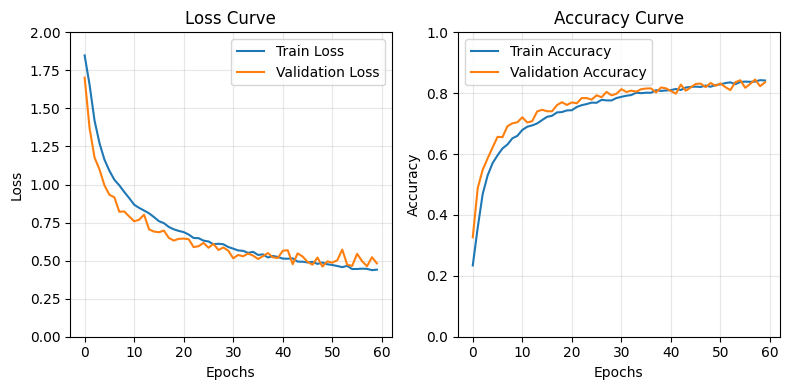

In [0]:
train_loss = CNN_History.history['loss']
val_loss = CNN_History.history['val_loss']
train_accuracy = CNN_History.history['accuracy']
val_accuracy = CNN_History.history['val_accuracy']

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].plot(train_loss, label='Train Loss')
ax[0].plot(val_loss, label='Validation Loss')
ax[0].set_title('Loss Curve')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].set_ylim([0, 2])
ax[0].grid(alpha=0.3)

ax[1].plot(train_accuracy, label='Train Accuracy')
ax[1].plot(val_accuracy, label='Validation Accuracy')
ax[1].set_title('Accuracy Curve')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
ax[1].set_ylim([0, 1])
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [0]:
train_CNNresult = model.evaluate(train_images_CNNreshaped, Y_train_cat)
test_CNNresult = model.evaluate(test_images_CNNreshaped, Y_test_cat)

print("Train Loss: {:.2f}%".format(train_CNNresult[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_CNNresult[1] * 100))

print("\nTest Loss: {:.2f}%".format(test_CNNresult[0] * 100))
print("Test Accuracy: {:.2f}%".format(test_CNNresult[1] * 100))

154/154 [==============================] - 1s 2ms/step - loss: 0.4820 - accuracy: 0.8361
Train Loss: 25.22%
Train Accuracy: 91.04%

Test Loss: 48.20%
Test Accuracy: 83.61%


In [0]:
y_predCNN_prob = model.predict(test_images_CNNreshaped)  # Predict probabilities
y_predCNN = np.argmax(y_predCNN_prob, axis=1)   # Convert to class labels
y_true = np.argmax(Y_test_cat, axis=1)   # Convert one-hot encoded labels to class indices

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_predCNN, target_names=classes))

154/154 [==============================] - 2s 2ms/step
Classification Report:
              precision    recall  f1-score   support

    surprise       0.93      0.85      0.89       699
        fear       0.94      0.94      0.94       671
     disgust       0.87      0.74      0.80       723
       happy       0.86      0.86      0.86       718
         sad       0.76      0.78      0.77       701
       angry       0.90      0.90      0.90       690
     neutral       0.65      0.81      0.72       698

    accuracy                           0.84      4900
   macro avg       0.85      0.84      0.84      4900
weighted avg       0.85      0.84      0.84      4900



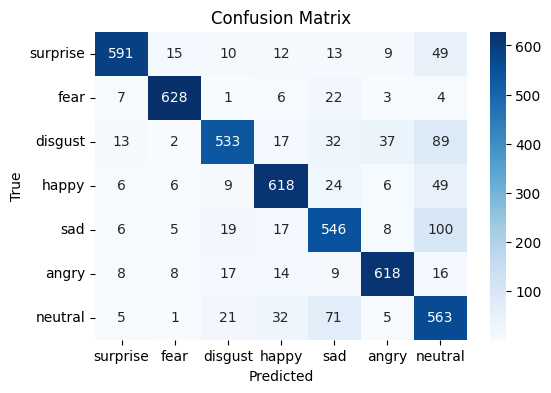

In [0]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_predCNN)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

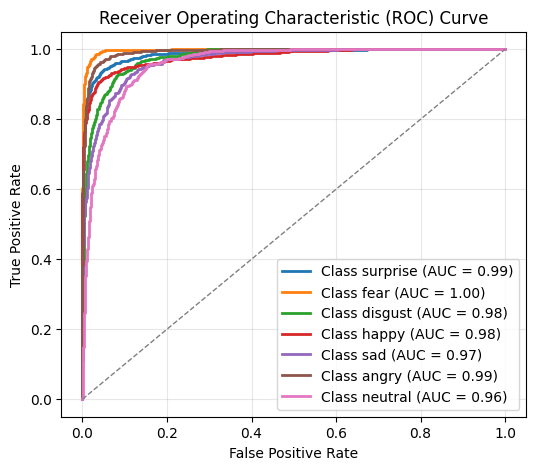

In [0]:
y_true_bin = label_binarize(y_true, classes=list(range(len(classes))))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_predCNN_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 5))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

#SQUEEZE-EXCITATION MODEL

# PREPROCESSING

In [0]:
dataset_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'
test_dataset_path ='/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test/'


#"/content/drive/MyDrive/RAF-DB/test"
train_path = '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train/'

#"/content/drive/MyDrive/RAF-DB/train"
test_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/test_labels (1).csv'
#"/content/drive/MyDrive/RAF-DB/test_labels.csv"
train_label_path = '/Workspace/Users/dimnaishvili@tbcbank.com.ge/f/train_labels (1).csv'
 #"/content/drive/MyDrive/RAF-DB/train_labels.csv"

In [0]:
image_counts = {}

for label in range(1, 8):  
    folder_path = os.path.join(dataset_path, str(label))
    image_counts[label] = len(os.listdir(folder_path))

In [0]:
df_counts = pd.DataFrame(list(image_counts.items()), columns=['Label', 'Image Count'])

In [0]:
df_counts


Label  Image Count
0      1         1290
1      2          281
2      3          717
3      4         4772
4      5         1982
5      6          705
6      7         2524

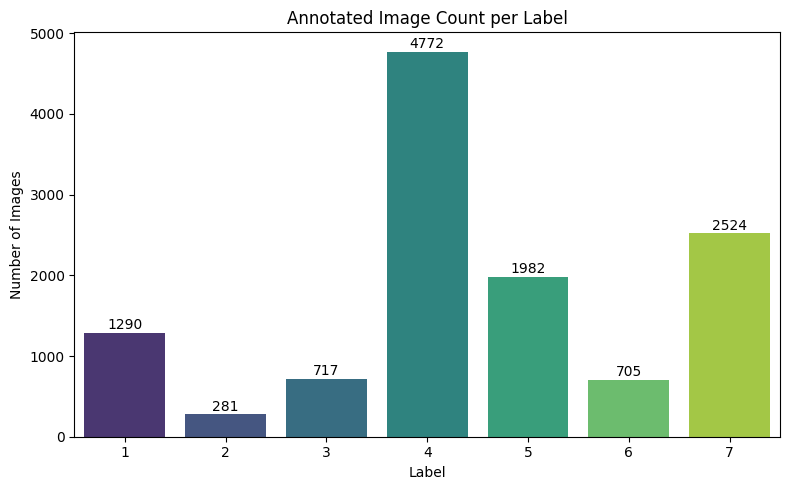

In [0]:
plt.figure(figsize=(8, 5))
bar_plot = sns.barplot(x='Label', y='Image Count', data=df_counts, palette='viridis')

for index, row in df_counts.iterrows():
    bar_plot.text(row.name, row['Image Count'] + 5, round(row['Image Count'], 2), 
                  color='black', ha="center", va="bottom")

plt.title('Annotated Image Count per Label')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

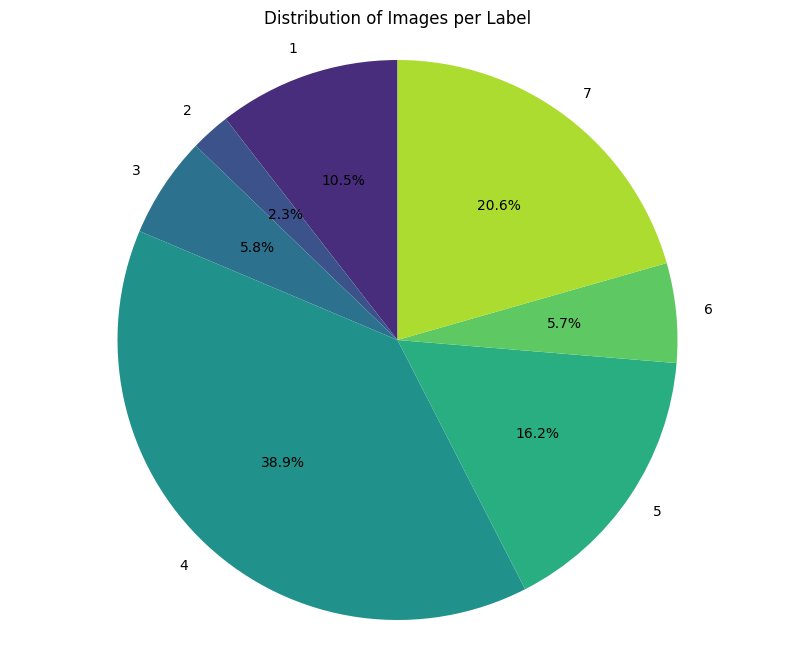

In [0]:
plt.figure(figsize=(10, 8))
plt.pie(df_counts['Image Count'], labels=df_counts['Label'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df_counts)))
plt.title('Distribution of Images per Label')
plt.axis('equal')  
plt.show()

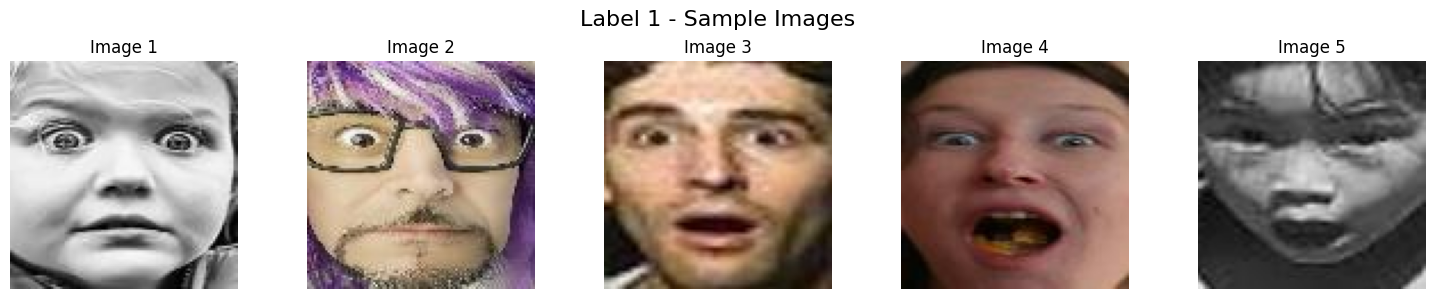

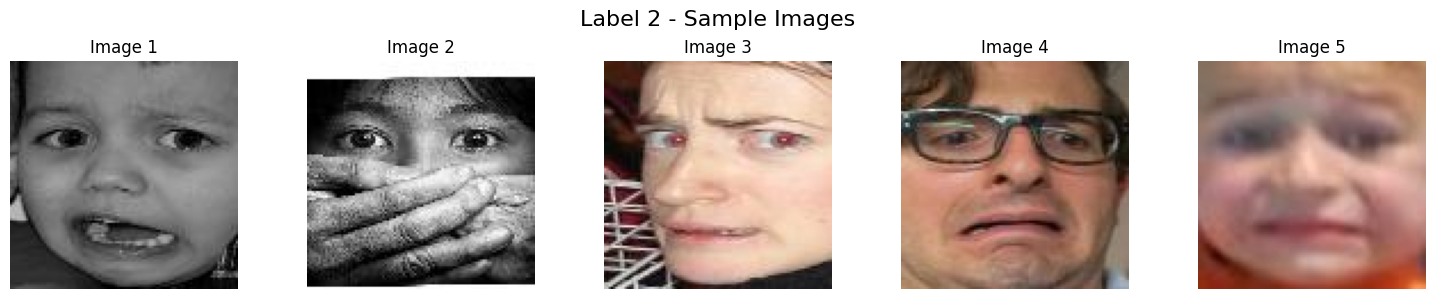

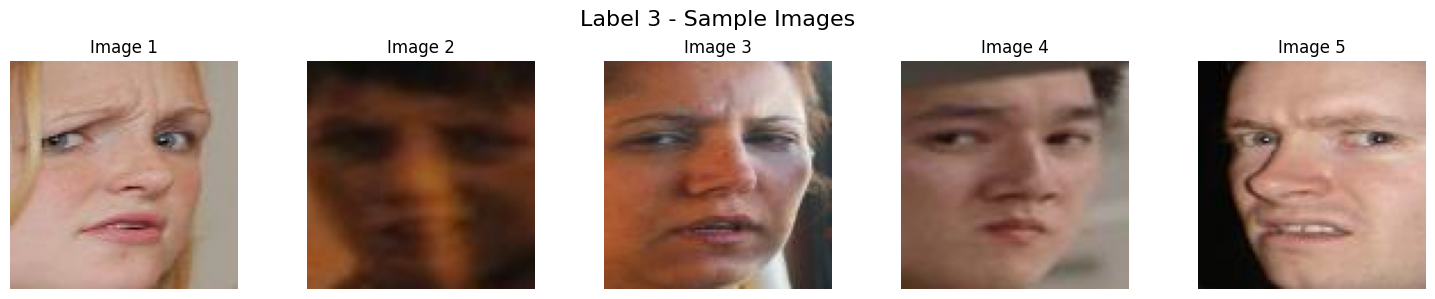

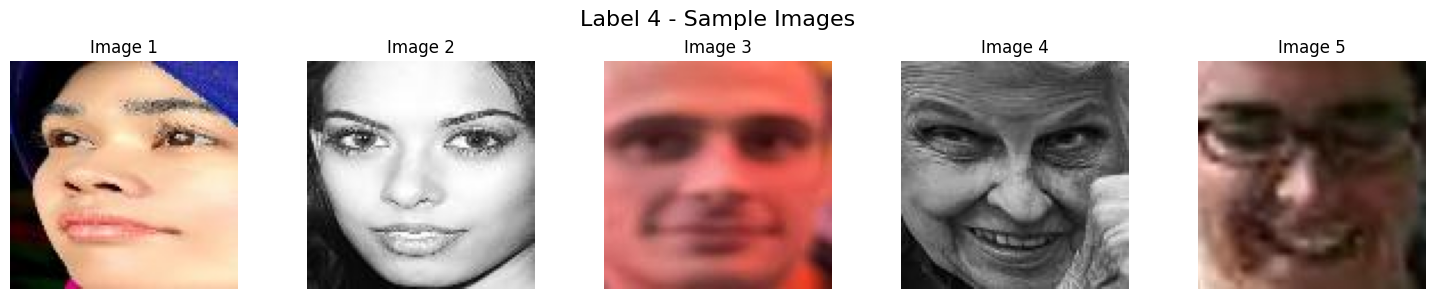

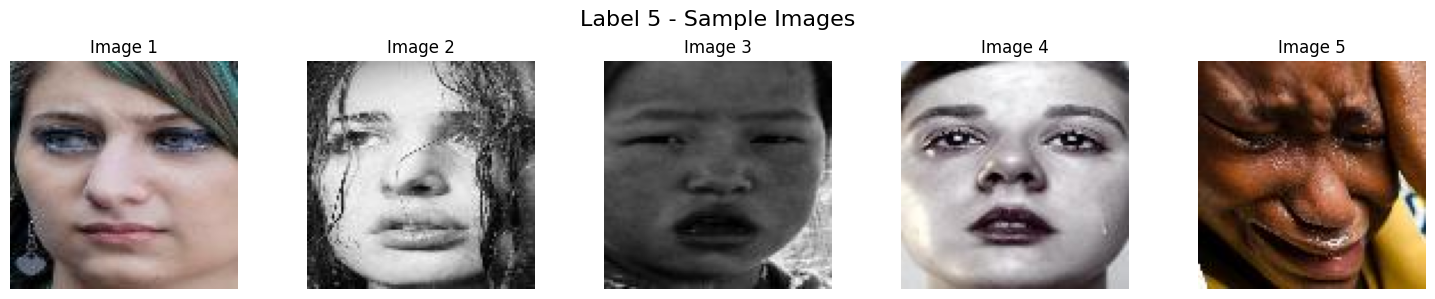

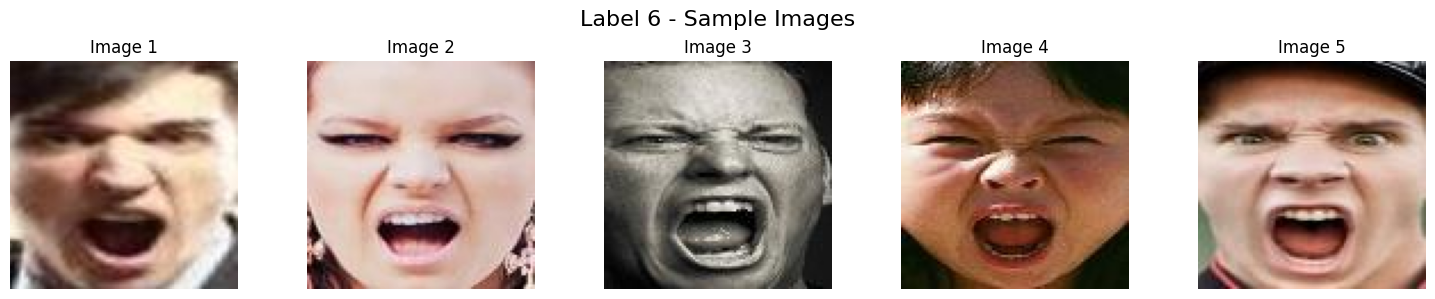

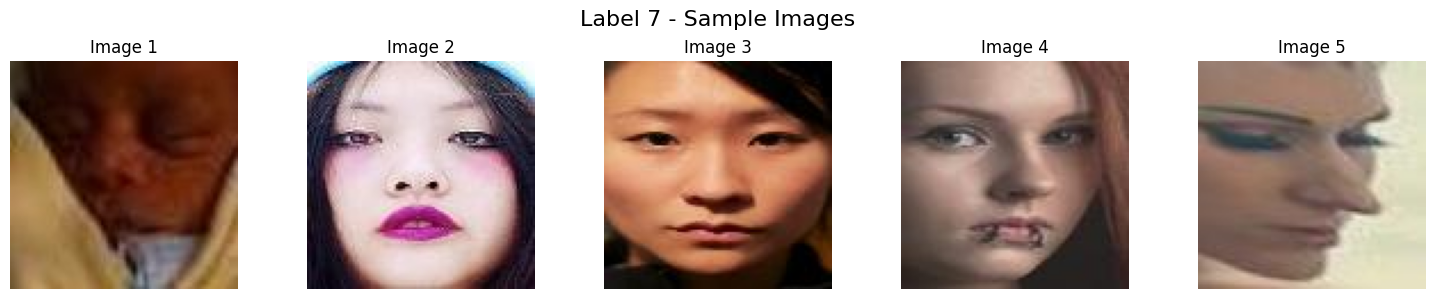

In [0]:
from PIL import Image
for label in range(1, 8):
    folder_path = os.path.join(dataset_path, str(label))
    image_files = os.listdir(folder_path)[:5]  

    plt.figure(figsize=(15, 3))
    plt.suptitle(f'Label {label} - Sample Images', fontsize=16)
    
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path)
        
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'Image {i+1}')

    plt.tight_layout()
    plt.show()

In [0]:
image_data = []
for label in range(1, 8):
    folder = os.path.join(dataset_path, str(label))
    for fname in os.listdir(folder):
        image_data.append({
            'image_path': os.path.join(folder, fname),
            'label'     : str(label)
        })
df_train = pd.DataFrame(image_data)

In [0]:
print("Original class distribution:")
print(df_train['label'].value_counts())

Original class distribution:
4    4772
7    2524
5    1982
1    1290
3     717
6     705
2     281
Name: label, dtype: int64


In [0]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(
    df_train[['image_path']], 
    df_train['label']
)
df_resampled = pd.DataFrame({
    'image_path': X_res.to_numpy().ravel(),
    'label'     : y_res
})

In [0]:
df_resampled

image_path label
0      /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     1
1      /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     1
2      /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     1
3      /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     1
4      /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     1
...                                                  ...   ...
33399  /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     7
33400  /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     7
33401  /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     7
33402  /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     7
33403  /dbfs/Workspace/Users/dimnaishvili@tbcbank.com...     7

[33404 rows x 2 columns]

In [0]:
import time
import shutil
import pathlib
import itertools

import cv2
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

In [0]:
df_resampled['label'] = df_resampled['label'].astype(str)

train_df, valid_df = train_test_split(
    df_resampled,
    train_size    = 0.8,
    stratify      = df_resampled['label'],
    random_state  = 42,
    shuffle       = True
)

test_data = []
for label in range(1, 8):
    folder = os.path.join(test_dataset_path, str(label))
    for fname in os.listdir(folder):
        test_data.append({
            'image_path': os.path.join(folder, fname),
            'label'     : str(label)
        })
test_df = pd.DataFrame(test_data)


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size = (100, 100)
channels = 3  
img_shape = (img_size[0], img_size[1], channels)
tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='image_path', y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df,
    x_col='image_path', y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=True
)

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='image_path', y_col='label',
    target_size=img_size,
    color_mode='rgb',
    class_mode='sparse',
    batch_size=batch_size,
    shuffle=False   # keep ordering for metrics/ROC curves, etc.
)

Found 26723 validated image filenames belonging to 7 classes.
Found 6681 validated image filenames belonging to 7 classes.
Found 3068 validated image filenames belonging to 7 classes.


In [0]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
# Uninstall any existing TF:
%pip uninstall -y tensorflow tf-nightly

# Install the last 2.12 release (built and tested for CUDA 11.8 on Linux):
%pip install tensorflow==2.12.0

dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Successfully uninstalled tensorflow-2.16.1
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.5 MB/s eta 0:00:00
     ━━

In [0]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


#MODEL TRAINING

In [0]:
class SEBlock(layers.Layer):
    def __init__(self, channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = layers.GlobalAveragePooling2D()
        self.fc1 = layers.Dense(channels // reduction_ratio, activation='relu')
        self.fc2 = layers.Dense(channels, activation='sigmoid')

    def call(self, inputs):
        se = self.squeeze(inputs)
        se = self.fc1(se)
        se = self.fc2(se)
        se = tf.reshape(se, [-1, 1, 1, tf.shape(inputs)[-1]])
        return inputs * se

img_size = (100, 100)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

inputs = layers.Input(shape=img_shape)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(inputs)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.Conv2D(filters=512, kernel_size=(3, 3), activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

x = SEBlock(512)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(7, activation="softmax")(x)  

model = Model(inputs=inputs, outputs=outputs)

model.summary()
model.compile (Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy', metrics=["accuracy"])


2025-05-22 10:24:44.692503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79088 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856 

In [0]:
%pip install mlflow dagshub


Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 443.9/443.9 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.0/119.0 kB 20.1 MB/s eta 0:00:00
     ━

In [0]:
import dagshub
dagshub.init(repo_name="Emotion_Recognition", repo_owner="dimna21", mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=898037fb-d984-4aab-af05-73e58b086591&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=17e3bf2516f205c2e80f46848f1999d2861e5c10d9f478249b7a65492c966fe5




Accessing as dimna21

Initialized MLflow to track repo "dimna21/Emotion_Recognition"

Repository dimna21/Emotion_Recognition initialized!

In [0]:
from dagshub import init
import mlflow
import mlflow.tensorflow

# (this will set MLFLOW_TRACKING_URI, USERNAME and PASSWORD for you)
init(repo_name="Emotion_Recognition", repo_owner="dimna21", mlflow=True)

# (optional) pick an experiment name
mlflow.set_experiment("Emotion_Recognition_2")

# enable automatic logging of all your args, metrics, metrics and models
mlflow.tensorflow.autolog()

# your existing callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy', patience=10,
    restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    filepath='/tmp/best_CNNModel',
    monitor='val_accuracy',
    save_best_only=True,
    save_format='tf'
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Initialized MLflow to track repo "dimna21/Emotion_Recognition"

Repository dimna21/Emotion_Recognition initialized!

2025/05/22 10:27:09 INFO mlflow.tracking.fluent: Experiment with name 'Emotion_Recognition_2' does not exist. Creating a new experiment.
2025/05/22 10:27:13 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f0904d4819bf488eb39c629ac0cbab4b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/05/22 10:27:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/05/22 10:27:15 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/5


2025-05-22 10:27:23.741034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2025-05-22 10:27:26.413988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2025-05-22 10:27:26.510672: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-05-22 10:27:27.012965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-05-22 10:27:27.301242: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x56163873dff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-22 10:27:27.301303: I tensorflo

 141/1671 [=>............................] - ETA: 9:14 - loss: 1.9818 - accuracy: 0.1822

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 1.6492 - accuracy: 0.3516

2025-05-22 10:35:12.350576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1671/1671 [==============================] - 695s 411ms/step - loss: 1.6492 - accuracy: 0.3516 - val_loss: 1.4440 - val_accuracy: 0.5091
Epoch 2/5
 140/1671 [=>............................] - ETA: 5:32 - loss: 1.1699 - accuracy: 0.5622

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.9019 - accuracy: 0.6821

1671/1671 [==============================] - 438s 262ms/step - loss: 0.9019 - accuracy: 0.6821 - val_loss: 0.5831 - val_accuracy: 0.7918
Epoch 3/5
 140/1671 [=>............................] - ETA: 4:36 - loss: 0.5580 - accuracy: 0.8076

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.4708 - accuracy: 0.8390

1671/1671 [==============================] - 377s 226ms/step - loss: 0.4708 - accuracy: 0.8390 - val_loss: 0.3923 - val_accuracy: 0.8672
Epoch 4/5
 140/1671 [=>............................] - ETA: 4:32 - loss: 0.2728 - accuracy: 0.9116

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.9101

1671/1671 [==============================] - 494s 296ms/step - loss: 0.2685 - accuracy: 0.9101 - val_loss: 0.3199 - val_accuracy: 0.8999
Epoch 5/5
 140/1671 [=>............................] - ETA: 4:47 - loss: 0.1787 - accuracy: 0.9442

*** WARNING: max output size exceeded, skipping output. ***

1671/1671 [==============================] - ETA: 0s - loss: 0.1900 - accuracy: 0.9376

1671/1671 [==============================] - 392s 235ms/step - loss: 0.1900 - accuracy: 0.9376 - val_loss: 0.3161 - val_accuracy: 0.9160


2025/05/22 11:07:21 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/05/22 11:07:21 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


In [0]:
import shutil
shutil.copytree('/tmp/best_CNNModel',
                '/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/best_CNNModel')

'/dbfs/Workspace/Users/dimnaishvili@tbcbank.com.ge/best_CNNModel'

In [0]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}")

2025-05-22 11:10:29.837477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


192/192 [==============================] - 38s 186ms/step - loss: 1.2642 - accuracy: 0.6933
Test Accuracy: 0.69


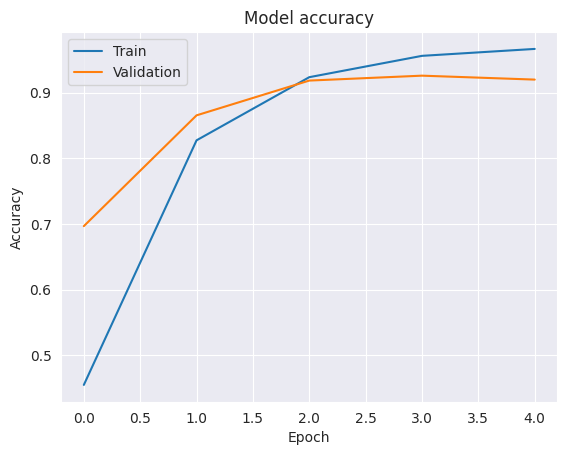

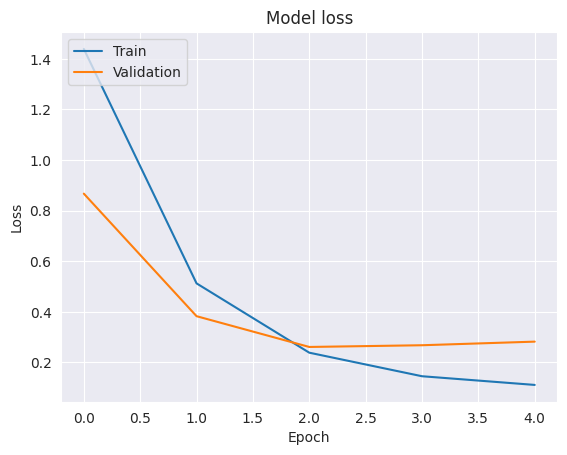

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [0]:
test_labels = test_gen_new.classes  
predictions = model.predict(test_gen_new)  
predicted_classes = np.argmax(predictions, axis=1)

2025-05-21 14:31:17.611948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


209/209 [==============================] - 55s 251ms/step


In [0]:
report = classification_report(test_labels, predicted_classes, target_names=list(test_gen_new.class_indices.keys()))
print(report)

              precision    recall  f1-score   support

           1       0.96      0.95      0.96       477
           2       0.98      0.99      0.99       477
           3       0.97      0.93      0.95       477
           4       0.94      0.80      0.86       477
           5       0.88      0.87      0.87       478
           6       0.97      1.00      0.98       477
           7       0.78      0.92      0.84       478

    accuracy                           0.92      3341
   macro avg       0.93      0.92      0.92      3341
weighted avg       0.93      0.92      0.92      3341



In [0]:
conf_matrix = confusion_matrix(test_labels, predicted_classes)

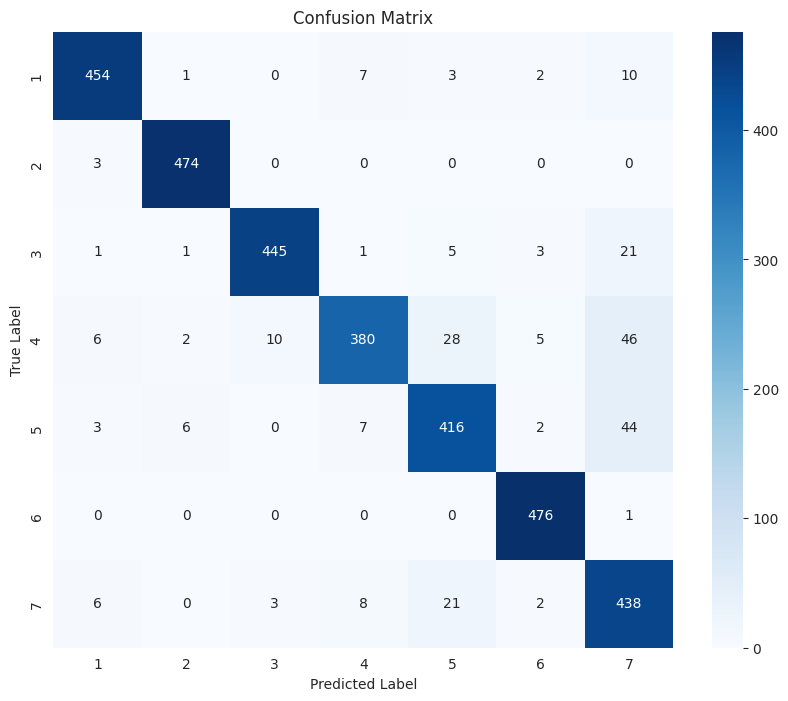

In [0]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen_new.class_indices.keys()), yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()